In [ ]:
!pip install augraphy
!pip install albumentations

Ячейка ниже удалит папку cyrill

И сделает клон ветки из удаленного репо в ваш colab

In [2]:
!rm -rf /content/cyrill
!git clone -b augmentation_pipline --single-branch https://github.com/TimofeyKaliakin/cyrill.git

Cloning into 'cyrill'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 170 (delta 90), reused 154 (delta 74), pack-reused 0 (from 0)
Receiving objects: 100% (170/170), 301.56 KiB | 6.70 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [1]:
import sys

sys.path.append('/content/cyrill')

from src.preprocessing.transforms import (ScaleAugmentation, ShearAugmentation, ErosionAugmentation, DilationAugmentation, GridDistortionAugmentation, MotionBlurAugmentation, ElasticTransformAugmentation, BadPhotoCopyAugmentation, WaterMarkAugmentation, ScribblesAugmentation)
from src.preprocessing.configs import PipelineConfig
from src.preprocessing.augmentation_pipeline import AugmentationPipeline
from datasets import load_dataset

import matplotlib.pyplot as plt
import numpy as np
import torch


In [ ]:
ds_test = load_dataset("Timka28/cyrillic", split="test")

# добавляем колонку с индексами
ds_test = ds_test.add_column("idx", list(range(len(ds_test))))

### 2. Инициализация аугментаций

In [3]:
scale_aug = ScaleAugmentation(
    scale_range=(0.3, 0.7)  # сильное уменьшение
)

shear_aug = ShearAugmentation(
    shear_x_range=(-25.0, 25.0),
    shear_y_range=(-15.0, 15.0),
)

grid_aug = GridDistortionAugmentation(
    num_steps_range=(6, 10),
    distort_limit_range=(0.3, 0.6),
)

elastic_aug = ElasticTransformAugmentation(
    alpha_range=(3.0, 6.0),
    sigma_range=(20.0, 40.0),
)

motion_blur_aug = MotionBlurAugmentation(
    blur_limit_range=(9, 21),
    angle_range=(0, 360),
    direction_range=(-1.0, 1.0),
)

dilation_aug = DilationAugmentation(
    kernal_size_range=(5, 9),
    iterations_range=(2, 4),
)

erosion_aug = ErosionAugmentation(
    kernal_size_range=(5, 9),
    iterations_rnage=(2, 4),
)

scribbles_aug = ScribblesAugmentation(
    size_range=(300, 500),
    count_range=(1, 4),
    thickness_range=(1, 2),
    brightness_values=(64, 128),
    rotation_range=(0, 360),
)

watermark_aug = WaterMarkAugmentation(
    words=("COPY", "DRAFT", "SAMPLE", "CONFIDENTIAL"),
    font_size_range=(3, 10),
    font_thickness_range=(2, 5),
    rotation_range=(0, 360),
)

bad_photocopy_aug = BadPhotoCopyAugmentation(
    noise_type_range = (1, 3),
    noise_iteration_range = (2, 4),
    noise_size_range = (2, 5),
    noise_sparsity_range = (0.1, 0.5),
    noise_concentration_range = (0.1, 0.5),
)

### 3. Конфигурация пайплайна

In [4]:
demo_augmentations = {
    "scale": scale_aug,
    "shear": shear_aug,
    "grid": grid_aug,
    "elastic": elastic_aug,
    "motion_blur": motion_blur_aug,
    "dilation": dilation_aug,
    "erosion": erosion_aug,
    "scribbles": scribbles_aug,
    "watermark": watermark_aug,
    "bad_photocopy": bad_photocopy_aug,
}

config = PipelineConfig(
    p_aug=1.0,
    augmentations=demo_augmentations,
    aug_weights={k: 1 / len(demo_augmentations) for k in demo_augmentations},
    return_params=True,
)

### 4. Создание AugmentationPipeline

In [5]:
aug_pipeline = AugmentationPipeline(
    config=config,
)

### 5. HF transform-функция (адаптер)

In [6]:
# Здесь вам уже нужно подготовить обработку под свою модель
# но главное используйте aug_pipeline(img, idx) передавая idx
def hf_transform(batch):
    images = []
    aug_metas = []

    for img, idx in zip(batch["image"], batch["idx"]):
        img_aug, meta = aug_pipeline(img, idx=idx) # Применяем аугментационный пайплайн

        images.append(img_aug)
        aug_metas.append(meta)

    batch["image"] = images
    batch["aug_meta"] = aug_metas
    return batch

### 5. Применение пайплайна

In [7]:
ds_test_aug = ds_test.with_transform(
    hf_transform,
    columns=["image", "idx"],
    output_all_columns=True,
)

Далее этот датасет можно использовать для обучения модели, инференса и тд. К 30% изображений в нем будет применяться аугментация

### 6. Визуализация результатов

In [25]:
import random

chosen = []
tries = 0

while len(chosen) < 12 and tries < 2000:
    idx = random.randint(0, len(ds_test_aug) - 1)
    batch = ds_test_aug[idx:int(idx+1)]

    meta = batch["aug_meta"][0]
    if meta["applied"]:
        chosen.append(idx)

    tries += 1

original_images = []
augmented_images = []
metas = []

for idx in chosen:
    # оригинал — из исходного датасета
    original_images.append(ds_test[idx]["image"])

    # аугментированное — из with_transform
    sample_aug = ds_test_aug[idx]

    augmented_images.append(sample_aug["image"])
    metas.append(sample_aug["aug_meta"])

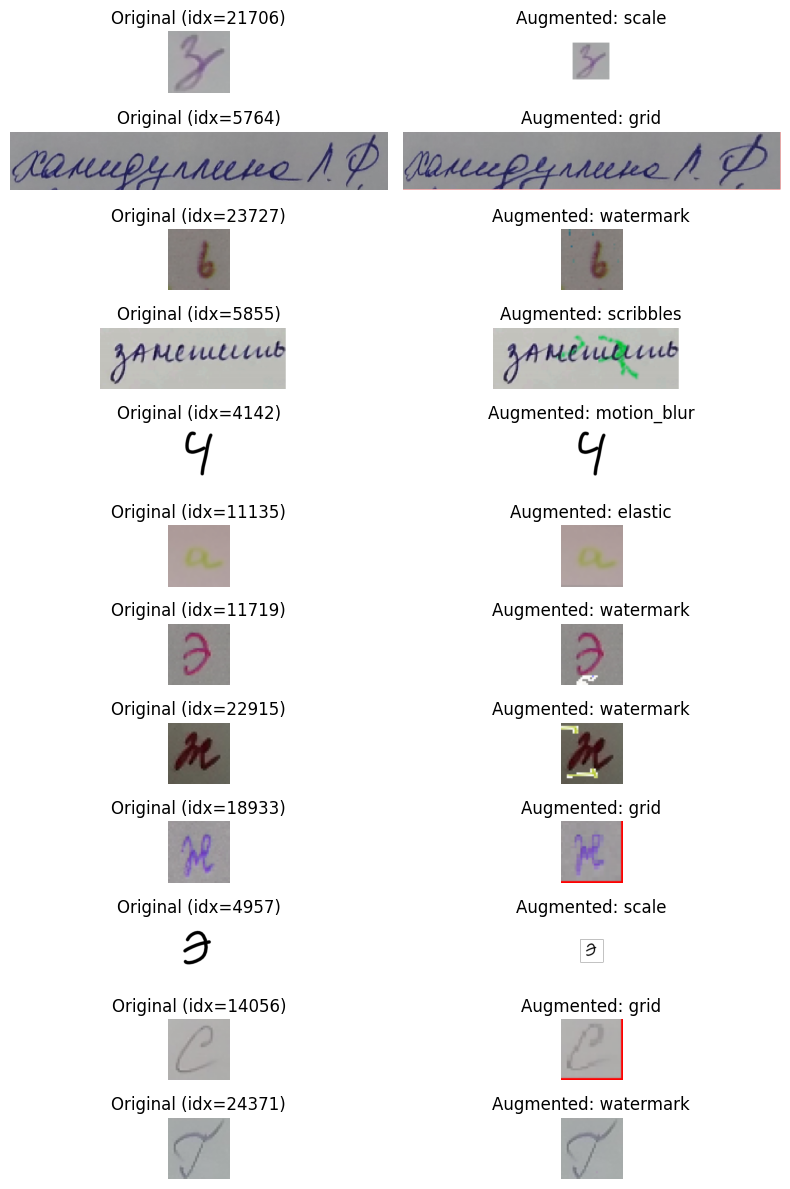

In [26]:
fig, axes = plt.subplots(len(chosen), 2, figsize=(8, 12))

for i, idx in enumerate(chosen):
    # Оригинал
    axes[i, 0].imshow(original_images[i], cmap="gray")
    axes[i, 0].set_title(f"Original (idx={idx})")
    axes[i, 0].axis("off")

    # После ds_test_aug (with_transform)
    axes[i, 1].imshow(augmented_images[i], cmap="gray")

    meta = metas[i]
    if meta["applied"]:
        title = f"Augmented: {meta['name']}"
    else:
        title = "No augmentation"

    axes[i, 1].set_title(title)
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

### 7. Посмотреть параметры аугментаций

In [ ]:
for idx, meta in zip(chosen, metas):
    print(f"idx={idx}")
    print(meta)
    print("-" * 40)